## Dueling DQN
&emsp;&emsp;Wang等人在DQN算法的基础上，通过对其网络结构进行改变，提出一种带竞争网络（Dueling network）的竞争DQN（Dueling DQN）算法。该算法采用一种无模型的强化学习神经网络结构，核心思想在于：在神经网络内部把动作值函数分解为状态值函数   和动作优势函数。这样把与动作相关的Q值函数转化为与动作无关的V值函数和与动作相关的优势函数两个部分。Dueling DQN算法的竞争网络结构<br>
&emsp;&emsp;在竞争网络结构中，<br>
&emsp;&emsp;（1）上路输出状态值函数，表示状态s本身所具有的价值；<br>
&emsp;&emsp;（2）下路输出动作优势函数，表示在状态s处选择动作a时所得的到回报，与状态s本身的价值之间的（即所有可能动作带来的平均回报）的差异，也就是：<br>
<center>A(s,a)=Q(s,a)-V(s)</center>

&emsp;&emsp;（3）通过全连接将上下路合并（求和），输出动作值函数Q(s,a)。<br>
&emsp;&emsp;Dueling DQN的出发点在于，多数状态没有必要估计每个动作的价值。在将Q函数的估计分为两步后，先估计状态的价值，在有新动作加入时，就可以基于现有的V函数来学习动作的价值，而不需要从零开始学习。因此，竞争网络能够有效解决奖励偏见（reward-bias）问题，动作越多，Q函数的泛化性也越好。<br>


In [1]:
import gym, random, pickle, os.path, math, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import pdb

from atari_wrappers import make_atari, wrap_deepmind,LazyFrames
from IPython.display import clear_output
from tensorboardX import SummaryWriter

USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

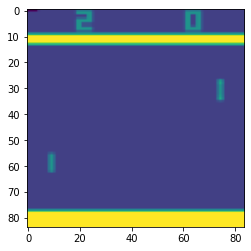

In [2]:
# Create and wrap the environment
env = make_atari('PongNoFrameskip-v4') # only use in no frameskip environment
env = wrap_deepmind(env, scale = False, frame_stack=True )
n_actions = env.action_space.n
state_dim = env.observation_space.shape

# env.render()
test = env.reset()
for i in range(100):
    test = env.step(env.action_space.sample())[0]

plt.imshow(test._force()[...,0])

#plt.imshow(env.render("rgb_array"))
# env.close()

Dueling DQN的出发点在于，多数状态没有估计每个动作价值的必要。在将Q函数的估计分为两步后，先估计状态的价值，在有新动作加入时，就可以基于现有的V函数来学习动作的价值，而不需要从零开始学习。因此，竞争网络能够有效解决奖励偏见（reawra-bias）问题，动作越多，Q函数的泛化性也越好。<br>
<center><img src="./image/图Dueling.png"  height="500" width="250"></center><br>
这样做会让Q值的学习更稳健一点。这是因为它系统的区分了那些reward是由状态带来的，哪些是由动作带来的。<br>

In [3]:
class Dueling_DQN(nn.Module):
    def __init__(self, input_shape, num_outputs):
        super(Dueling_DQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_outputs
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, num_outputs)
        )
        
        self.value = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        advantage = self.advantage(x)
        value     = self.value(x)
        return value + advantage  - advantage.mean()
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

In [4]:
class Memory_Buffer(object):
    def __init__(self, memory_size=1000):
        self.buffer = []
        self.memory_size = memory_size
        self.next_idx = 0
        
    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if len(self.buffer) <= self.memory_size: # buffer not full
            self.buffer.append(data)
        else: # buffer is full
            self.buffer[self.next_idx] = data
        self.next_idx = (self.next_idx + 1) % self.memory_size

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.size() - 1)
            data = self.buffer[idx]
            state, action, reward, next_state, done= data
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            
            
        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones
    
    def size(self):
        return len(self.buffer)


In [5]:
class Dueling_DQNAgent: 
    def __init__(self, input_shape, action_space = [], USE_CUDA = False, memory_size = 10000, epsilon  = 1, lr = 1e-4):
        self.epsilon = epsilon
        self.action_space = action_space
        self.memory_buffer = Memory_Buffer(memory_size)
        self.Dueling_DQN = Dueling_DQN(input_shape = input_shape, num_outputs = action_space.n)
        self.Dueling_DQN_target = Dueling_DQN(input_shape = input_shape, num_outputs = action_space.n)
        self.Dueling_DQN_target.load_state_dict(self.Dueling_DQN.state_dict())


        self.USE_CUDA = USE_CUDA
        if USE_CUDA:
            self.Dueling_DQN = self.Dueling_DQN.cuda()
            self.Dueling_DQN_target = self.Dueling_DQN_target.cuda()
        self.optimizer = optim.RMSprop(self.Dueling_DQN.parameters(),lr=lr, eps=0.001, alpha=0.95)

    def observe(self, lazyframe):
        # from Lazy frame to tensor
        state =  torch.from_numpy(lazyframe._force().transpose(2,0,1)[None]/255).float()
        if self.USE_CUDA:
            state = state.cuda()
        return state

    def value(self, state):
        q_values = self.Dueling_DQN(state)
        return q_values
    
    def act(self, state, epsilon = None):
        """
        sample actions with epsilon-greedy policy
        recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
        """
        if epsilon is None: epsilon = self.epsilon

        q_values = self.value(state).cpu().detach().numpy()
        if random.random()<epsilon:
            aciton = random.randrange(self.action_space.n)
        else:
            aciton = q_values.argmax(1)[0]
        return aciton
    
    def compute_td_loss(self, states, actions, rewards, next_states, is_done, gamma=0.99):
        """ Compute td loss using torch operations only. Use the formula above. """
        actions = torch.tensor(actions).long()    # shape: [batch_size]
        rewards = torch.tensor(rewards, dtype =torch.float)  # shape: [batch_size]
        is_done = torch.tensor(is_done,dtype = torch.uint8)  # shape: [batch_size]
        
        if self.USE_CUDA:
            actions = actions.cuda()
            rewards = rewards.cuda()
            is_done = is_done.cuda()

        # get q-values for all actions in current states
        predicted_qvalues = self.Dueling_DQN(states)

        # select q-values for chosen actions
        predicted_qvalues_for_actions = predicted_qvalues[
          range(states.shape[0]), actions
        ]

        # compute q-values for all actions in next states
        predicted_next_qvalues = self.Dueling_DQN_target(next_states) # YOUR CODE

        # compute V*(next_states) using predicted next q-values
        next_state_values =  predicted_next_qvalues.max(-1)[0] # YOUR CODE

        # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
        target_qvalues_for_actions = rewards + gamma *next_state_values # YOUR CODE

        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_qvalues_for_actions = torch.where(
            is_done, rewards, target_qvalues_for_actions)

        # mean squared error loss to minimize
        #loss = torch.mean((predicted_qvalues_for_actions -
        #                   target_qvalues_for_actions.detach()) ** 2)
        loss = F.smooth_l1_loss(predicted_qvalues_for_actions, target_qvalues_for_actions.detach())

        return loss
    
    def sample_from_buffer(self, batch_size):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            idx = random.randint(0, self.memory_buffer.size() - 1)
            data = self.memory_buffer.buffer[idx]
            frame, action, reward, next_frame, done= data
            states.append(self.observe(frame))
            actions.append(action)
            rewards.append(reward)
            next_states.append(self.observe(next_frame))
            dones.append(done)
        return torch.cat(states), actions, rewards, torch.cat(next_states), dones

    def learn_from_experience(self, batch_size):
        if self.memory_buffer.size() > batch_size:
            states, actions, rewards, next_states, dones = self.sample_from_buffer(batch_size)
            td_loss = self.compute_td_loss(states, actions, rewards, next_states, dones)
            self.optimizer.zero_grad()
            td_loss.backward()
            for param in self.Dueling_DQN.parameters():
                param.grad.data.clamp_(-1, 1)

            self.optimizer.step()
            return(td_loss.item())
        else:
            return(0)
    

In [ ]:
# if __name__ == '__main__':
    
# Training DQN in PongNoFrameskip-v4 
env = make_atari('PongNoFrameskip-v4')
env = wrap_deepmind(env, scale = False, frame_stack=True)

gamma = 0.99
epsilon_max = 1
epsilon_min = 0.01
eps_decay = 30000
frames = 1000000
USE_CUDA = True
learning_rate = 2e-4
max_buff = 100000
update_tar_interval = 1000
batch_size = 32
print_interval = 1000
log_interval = 1000
learning_start = 10000
win_reward = 18     # Pong-v4
win_break = True

frame = env.reset()
action_space = env.action_space
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
state_channel = env.observation_space.shape[2]
input_shape = frame._force().transpose(2,0,1).shape
agent = Dueling_DQNAgent(input_shape = input_shape, action_space= action_space, USE_CUDA = USE_CUDA, lr = learning_rate)

episode_reward = 0
all_rewards = []
losses = []
episode_num = 0
is_win = False
# tensorboard
summary_writer = SummaryWriter(log_dir = "Dueling_DQN", comment= "good_makeatari")

# e-greedy decay
epsilon_by_frame = lambda frame_idx: epsilon_min + (epsilon_max - epsilon_min) * math.exp(
            -1. * frame_idx / eps_decay)
# plt.plot([epsilon_by_frame(i) for i in range(10000)])

for i in range(frames):
    epsilon = epsilon_by_frame(i)
    state_tensor = agent.observe(frame)
    action = agent.act(state_tensor, epsilon)
    
    next_frame, reward, done, _ = env.step(action)
    
    episode_reward += reward
    agent.memory_buffer.push(frame, action, reward, next_frame, done)
    frame = next_frame
    
    loss = 0
    if agent.memory_buffer.size() >= learning_start:
        loss = agent.learn_from_experience(batch_size)
        losses.append(loss)

    if i % print_interval == 0:
        print("frames: %5d, reward: %5f, loss: %4f, epsilon: %5f, episode: %4d" % (i, np.mean(all_rewards[-10:]), loss, epsilon, episode_num))
        summary_writer.add_scalar("Temporal Difference Loss", loss, i)
        summary_writer.add_scalar("Mean Reward", np.mean(all_rewards[-10:]), i)
        summary_writer.add_scalar("Epsilon", epsilon, i)
        
    if i % update_tar_interval == 0:
        agent.Dueling_DQN_target.load_state_dict(agent.Dueling_DQN.state_dict())
    
    if done:
        
        frame = env.reset()
        
        all_rewards.append(episode_reward)
        episode_reward = 0
        episode_num += 1
        avg_reward = float(np.mean(all_rewards[-100:]))

summary_writer.close()
torch.save(agent.Dueling_DQN.state_dict(), "trained model/Dueling_DQN_dict.pth.tar")

/home/ouyangz/.conda/envs/gym/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ouyangz/.conda/envs/gym/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


frames:     0, reward:   nan, loss: 0.000000, epsilon: 1.000000, episode:    0


frames:  1000, reward:   nan, loss: 0.000000, epsilon: 0.967544, episode:    0
frames:  2000, reward: -21.000000, loss: 0.000000, epsilon: 0.936152, episode:    1
frames:  3000, reward: -20.000000, loss: 0.000000, epsilon: 0.905789, episode:    3
frames:  4000, reward: -20.250000, loss: 0.000000, epsilon: 0.876422, episode:    4
frames:  5000, reward: -20.400000, loss: 0.000000, epsilon: 0.848017, episode:    5
frames:  6000, reward: -20.500000, loss: 0.000000, epsilon: 0.820543, episode:    6
frames:  7000, reward: -20.625000, loss: 0.000000, epsilon: 0.793971, episode:    8
frames:  8000, reward: -20.666667, loss: 0.000000, epsilon: 0.768269, episode:    9
frames:  9000, reward: -20.700000, loss: 0.000000, epsilon: 0.743410, episode:   10
frames: 10000, reward: -21.000000, loss: 0.000380, epsilon: 0.719366, episode:   12
frames: 11000, reward: -20.900000, loss: 0.000253, epsilon: 0.696110, episode:   13
frames: 12000, reward: -20.900000, loss: 0.000311, epsilon: 0.673617, episode:   

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_training(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-100:])))
    plt.plot(moving_average(rewards,20))
    plt.subplot(132)
    plt.title('loss, average on 100 stpes')
    plt.plot(moving_average(losses, 100),linewidth=0.2)
    plt.show()

plot_training(i, all_rewards, losses)